In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import einops
from src.models.Model_OctreeNCAV2 import OctreeNCAV2
from src.losses.LossFunctions import DiceBCELoss

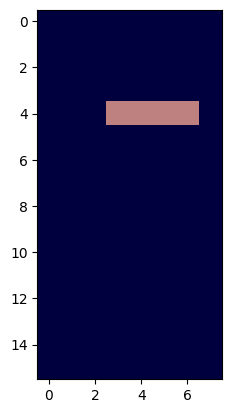

In [25]:
def create_sample(segmentation_padding: int):
    sample_width, sample_height = 16, 8
    sample = np.zeros((1, sample_width, sample_height, 1))
    segmentation = np.zeros((1, sample_width, sample_height, 1))
    bar_width = 1
    bar_height = 4
    x_start, y_start = np.random.randint(0, sample_width - bar_width), np.random.randint(0, sample_height - bar_height)
    sample[0, x_start:x_start + bar_width, y_start:y_start + bar_height, 0] = 1
    segmentation[0, max(x_start - segmentation_padding, 0):min(x_start + bar_width + segmentation_padding, 16),
                max(y_start - segmentation_padding, 0):min(y_start + bar_height + segmentation_padding, 16)] = 1
    return sample, segmentation

sample, segmentation = create_sample(0)
plt.imshow(sample[0, :, :, 0], cmap='gray')
plt.imshow(segmentation[0, :, :, 0], cmap='jet', alpha=0.5)

In [52]:
model = OctreeNCAV2(channel_n=4, fire_rate=0.5, 
                          device="cuda:0", hidden_size=24, 
                          input_channels=1, output_channels=1, 
                          steps=None, 
                          #octree_res_and_steps=[((16,8), 5), ((8,8), 5), ((4,4), 5), ((2,2), 5)],
                          octree_res_and_steps=[((16,8), 5)],
                          separate_models=False, compile=False, kernel_size=3)
model = model.to(model.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)
loss_function = DiceBCELoss()

In [60]:
for i in range(10000):
    sample_batch, segmentation_batch = [], []
    for b in range(3):
        sample, segmentation = create_sample(0)
        sample = einops.rearrange(sample, 'b h w c -> b c h w')
        segmentation = einops.rearrange(segmentation, 'b h w c -> b c h w')
        sample = torch.tensor(sample, dtype=torch.float32, device=model.device)
        segmentation = torch.tensor(segmentation, dtype=torch.float32, device=model.device)
        sample_batch.append(sample)
        segmentation_batch.append(segmentation)
    sample = torch.cat(sample_batch, dim=0)
    segmentation = torch.cat(segmentation_batch, dim=0)
    optimizer.zero_grad()
    out = model(sample, segmentation)
    loss = loss_function(out[0], out[1])
    loss.backward()
    optimizer.step()
    scheduler.step()
    if i % 100 == 0:
        print(f"Epoch {i} Loss: {loss.item():.2}, lr: {scheduler.get_last_lr()[0]:.2}")

/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 Loss: 0.91, lr: 0.0009
Epoch 100 Loss: 0.84, lr: 0.0009
Epoch 200 Loss: 1.2, lr: 0.0009
Epoch 300 Loss: 0.94, lr: 0.0009
Epoch 400 Loss: 1.2, lr: 0.0009
Epoch 500 Loss: 1.1, lr: 0.0009
Epoch 600 Loss: 0.79, lr: 0.0009
Epoch 700 Loss: 1.0, lr: 0.0009
Epoch 800 Loss: 0.91, lr: 0.0009
Epoch 900 Loss: 0.75, lr: 0.0009
Epoch 1000 Loss: 0.9, lr: 0.0009
Epoch 1100 Loss: 1.1, lr: 0.00089
Epoch 1200 Loss: 1.2, lr: 0.00089
Epoch 1300 Loss: 1.1, lr: 0.00089
Epoch 1400 Loss: 0.86, lr: 0.00089
Epoch 1500 Loss: 0.66, lr: 0.00089
Epoch 1600 Loss: 1.2, lr: 0.00089
Epoch 1700 Loss: 0.8, lr: 0.00089
Epoch 1800 Loss: 1.0, lr: 0.00089
Epoch 1900 Loss: 1.2, lr: 0.00089
Epoch 2000 Loss: 1.2, lr: 0.00089
Epoch 2100 Loss: 1.1, lr: 0.00089
Epoch 2200 Loss: 1.1, lr: 0.00089
Epoch 2300 Loss: 0.88, lr: 0.00088
Epoch 2400 Loss: 0.95, lr: 0.00088
Epoch 2500 Loss: 0.96, lr: 0.00088
Epoch 2600 Loss: 0.98, lr: 0.00088
Epoch 2700 Loss: 0.92, lr: 0.00088
Epoch 2800 Loss: 1.0, lr: 0.00088
Epoch 2900 Loss: 0.95, l

In [58]:
sample, segmentation = create_sample(0)
sample = einops.rearrange(sample, 'b h w c -> b c h w')
segmentation = einops.rearrange(segmentation, 'b h w c -> b c h w')
sample = torch.tensor(sample, dtype=torch.float32)
segmentation = torch.tensor(segmentation, dtype=torch.float32)
out = model(sample, segmentation)

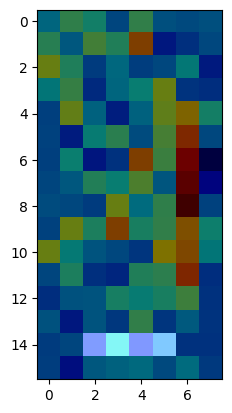

In [59]:
plt.imshow(sample[0].detach().cpu().numpy()[0, :, :], cmap='gray')
plt.imshow(out[0].detach().cpu().numpy()[0, :, :, :], cmap='jet', alpha=0.5)